<div align="center">

###### HW2

# National Tsing Hua University

#### Spring 2024

#### 11220IEEM 513600

#### Deep Learning and Industrial Applications
    
## Homework 3
</div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ROOT = '/content/drive/MyDrive/NTHU/Deep_Learning_HomeWork/HW3/wood'
ROOT = 'wood'
TRAIN_RATIO = 0.8
SEED = 42
DEVICE = 'cuda'

In [3]:
import os
import shutil
source_folder = '/content/drive/MyDrive/NTHU/Deep_Learning_HomeWork/HW3/wood'
target_folder = ROOT

if not os.path.exists(target_folder):
    shutil.copytree(source_folder, target_folder)

In [4]:
import numpy as np
import torch


torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


np.random.seed(SEED)

## Q1.
Download the MVTec Anomaly Detection Dataset from Kaggle (here). Select one type of product from the dataset. Document the following details about your dataset:

In [5]:
import os


# Number of defect classes
all_classes = os.listdir(os.path.join(ROOT, 'test'))
print(f'Number of defect classes is {len(all_classes[1:])}')

# Types of defect classes
print(f'Types of defect classes: {all_classes[1:]}')

Number of defect classes is 5
Types of defect classes: ['liquid', 'hole', 'color', 'good', 'combined']


In [6]:
# Number of images used in your datase
# Distribution of training and test data


import random
import typing as ty
from collections import defaultdict


def get_image_paths_by_class(directory: str) -> ty.Dict[str, list]:
    class_paths = defaultdict(list)

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                class_name = os.path.basename(root)
                class_paths[class_name].append(os.path.join(root, file))
    return class_paths


def split_dataset_by_class(image_paths_by_class, train_size=0.7, validation_size=0.0, seed=SEED):
    adjusted_train_size = train_size + validation_size
    train_image_paths, validation_image_paths, test_image_paths = [], [], []
    random.seed(seed)
    for class_name, paths in image_paths_by_class.items():
        random.shuffle(paths)
        train_count = int(len(paths) * adjusted_train_size)
        validation_count = int(len(paths) * validation_size)

        train_validation_split = paths[:train_count]
        validation_image_paths.extend(train_validation_split[:validation_count])
        train_image_paths.extend(train_validation_split[validation_count:])
        test_image_paths.extend(paths[train_count:])

    return train_image_paths, validation_image_paths, test_image_paths

train_dir = os.path.join(ROOT, 'test')

image_paths_by_class = get_image_paths_by_class(train_dir)
train_image_paths, validation_image_paths, test_image_paths = split_dataset_by_class(image_paths_by_class)

print(f'Total images in training set: {len(train_image_paths)}')
print(f'Total images in validation set: {len(validation_image_paths)}')
print(f'Total images in test set: {len(test_image_paths)}')


Total images in training set: 53
Total images in validation set: 0
Total images in test set: 26


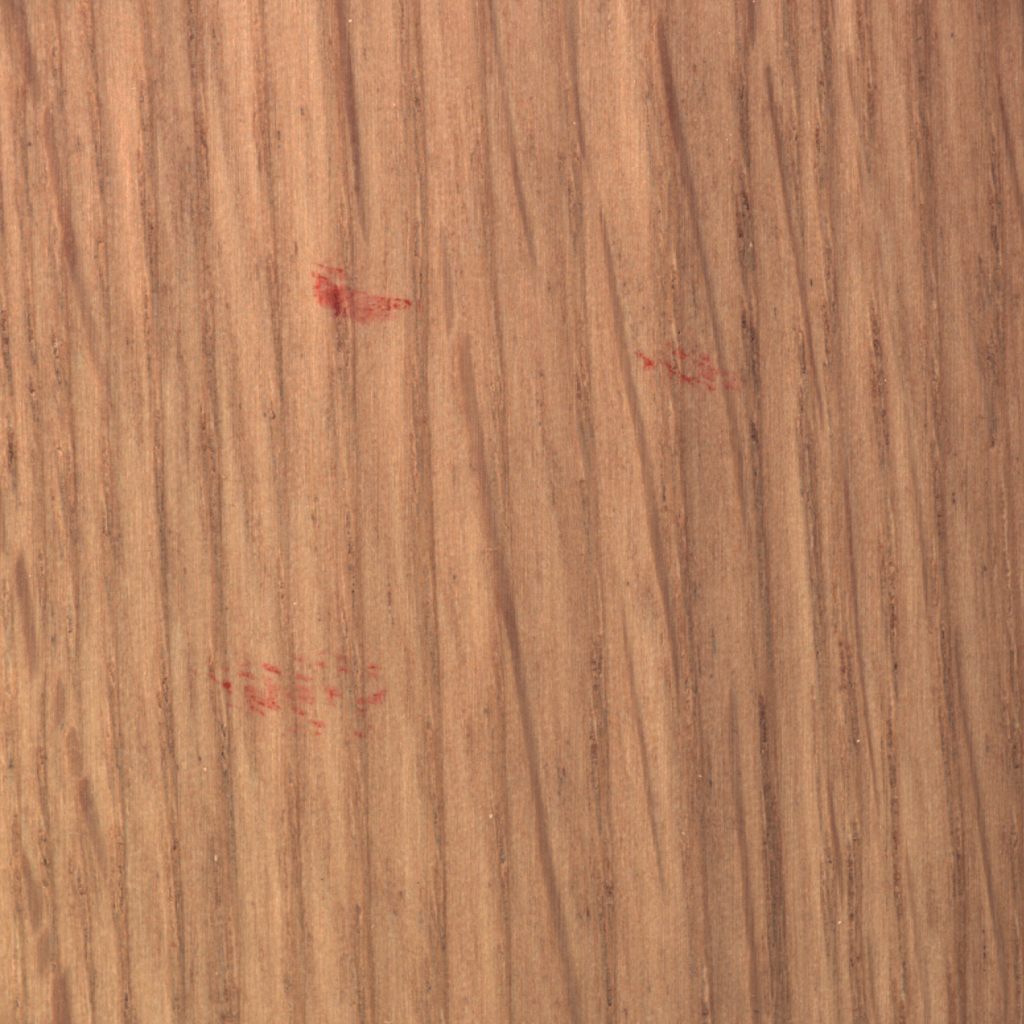

In [7]:
# Image dimensions
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


path = os.path.join(ROOT, 'test/color/000.png')
image = Image.open(path)
image

In [8]:
print(f'The image dimension are: {np.array(image).shape}')

The image dimension are: (1024, 1024, 3)


## Q2
Implement 4 different attempts to improve the model's performance trained on the dataset you choose in previous question. Ensure that at least one approach involves modifying the pre-trained model from TorchVision. Summarize the outcomes of each attempt, highlighting the best performing model and the key factors contributing to its success. You may also need to describe other hyperparameters you use in your experiment, like epochs, learning rate, and optimizer.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR



In [10]:
!TORCH_USE_CUDA_DSA=1

In [11]:
## Baseline approach
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 6)

        )

    def forward(self, x):
        return self.convs(x)


def freeze_weights(module):
    for param in module.parameters():
        param.requires_grad = False
    return None


def unfreeze_weights(module):
    for param in module.parameters():
        param.requires_grad = True
    return None


# Torchvision models
class TorchvisionResNet18(nn.Module):
    def __init__(self, num_classes: int = 6, is_pretrained: bool = False) -> None:
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=is_pretrained)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def freeze_feature_extractor(self):
        freeze_weights(self.model)
        unfreeze_weights(self.model.fc)

    def unfreeze_model(self):
        unfreeze_weights(self.model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class TorchVisionEfficientNetb0(nn.Module):
    def __init__(self, num_classes: int = 6, is_pretrained: bool = False) -> None:
        super().__init__()
        self.model = torchvision.models.efficientnet_b0(pretrained=is_pretrained)
        self.model.classifier = nn.Linear(self.model.classifier[-1].in_features, num_classes)

    def freeze_feature_extractor(self):
        freeze_weights(self.model)
        unfreeze_weights(self.model.classifier)

    def unfreeze_model(self):
        unfreeze_weights(self.model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)



# training utils
def create_transforms(input_size: int = 224):
    train_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, test_transform


class CustomImageDataset(Dataset):
    def __init__(
        self,
        image_paths: list,
        class_to_index: ty.Dict = None,
        transform: ty.Callable = None
    ) -> None:
        self.image_paths = image_paths
        self.transform = transform
        self.class_to_index = class_to_index if class_to_index is not None \
            else self._get_class_index()

    def _get_class_index(self):
        self.classes = sorted(set(path.split('/')[-2] for path in self.image_paths))
        return {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        img_path = self.image_paths[idx]
        label = img_path.split('/')[-2]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.class_to_index[label]


def create_data_loader(
        train_image_paths: list,
        test_image_paths: list,
        train_transform: ty.Callable = None,
        test_transform: ty.Callable = None,
        batch_size: int = 32) -> ty.Tuple[DataLoader]:

    train_dataset = CustomImageDataset(train_image_paths, None, train_transform)
    test_dataset = CustomImageDataset(test_image_paths, train_dataset.class_to_index, test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    return train_loader, test_loader


def train_one_epoch(model, criterion, optimizer, lr_scheduler, loader):
    model.train()

    total_loss = 0
    correct = 0
    total_samples = 0

    for features, labels in loader:
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(features)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = outputs.argmax(-1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    lr_scheduler.step()
    avg_loss = total_loss / len(loader)
    accuracy = correct / total_samples

    return avg_loss, accuracy


@torch.no_grad
def evaluate(model, criterion, loader):
    model.eval()

    total_loss = 0
    correct = 0
    total_samples = 0

    for features, labels in loader:
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(features)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        predicted = outputs.argmax(-1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total_samples

    return avg_loss, accuracy


def run_experiment(train_loader, test_loader, model, optimizer_class, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        avg_train_loss, train_accuracy = train_one_epoch(
            model, criterion, optimizer, lr_scheduler, train_loader
        )

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

    avg_test_loss, test_accuracy = evaluate(model, criterion, test_loader)

    return train_losses, train_accuracies, avg_test_loss, test_accuracy



In [12]:
def main():
    train_transform, test_transform = create_transforms()
    train_loader, test_loader = create_data_loader(
        train_image_paths, test_image_paths, train_transform, test_transform, batch_size=32
    )

    # Experiment 1: Simple CNN (1)
    model = SimpleCNN().to(DEVICE)
    num_epochs = 30
    optimizer_class = optim.SGD
    learning_rate = 1e-3

    print('=============== Experiment 1 ===============')
    print(f'model: SimpleCNN')
    print(f'Number of epoch: {num_epochs}')
    print(f'Optimizer: Adam')
    print(f'Learning rate: {learning_rate}')

    train_losses, train_accuracies, avg_test_loss, test_accuracy = run_experiment(
        train_loader, test_loader, model, optimizer_class, learning_rate, num_epochs
    )

    print('--------------- Performance ---------------')
    print(f'Training loss: {train_losses[-1]}')
    print(f'Training acc: {train_accuracies[-1]}')

    print(f'Testing loss: {avg_test_loss}')
    print(f'Testing acc: {test_accuracy}')

    del model

    # Experiment 2: Simple CNN (2)
    model = SimpleCNN().to(DEVICE)
    num_epochs = 30
    optimizer_class = optim.Adam
    learning_rate = 1e-3

    print('=============== Experiment 2 ===============')
    print(f'model: SimpleCNN')
    print(f'Number of epoch: {num_epochs}')
    print(f'Optimizer: Adam')
    print(f'Learning rate: {learning_rate}')

    train_losses, train_accuracies, avg_test_loss, test_accuracy = run_experiment(
        train_loader, test_loader, model, optimizer_class, learning_rate, num_epochs
    )

    print('--------------- Performance ---------------')
    print(f'Training loss: {train_losses[-1]}')
    print(f'Training acc: {train_accuracies[-1]}')

    print(f'Testing loss: {avg_test_loss}')
    print(f'Testing acc: {test_accuracy}')

    del model

    # Experiment 3: ResNet18 (train from srach)
    model = TorchvisionResNet18(is_pretrained=False).to(DEVICE)
    num_epochs = 30
    optimizer_class = optim.Adam
    learning_rate = 1e-3

    print('=============== Experiment 3 ===============')
    print(f'model: ResNet 18 (train from scratch)')
    print(f'Number of epoch: {num_epochs}')
    print(f'Optimizer: Adam')
    print(f'Learning rate: {learning_rate}')

    train_losses, train_accuracies, avg_test_loss, test_accuracy = run_experiment(
        train_loader, test_loader, model, optimizer_class, learning_rate, num_epochs
    )

    print('--------------- Performance ---------------')
    print(f'Training loss: {train_losses[-1]}')
    print(f'Training acc: {train_accuracies[-1]}')

    print(f'Testing loss: {avg_test_loss}')
    print(f'Testing acc: {test_accuracy}')

    del model

    # Experiment 4: ResNet18 (transfer learning)
    model = TorchvisionResNet18(is_pretrained=True).to(DEVICE)
    model.freeze_feature_extractor()
    num_epochs = 30
    optimizer_class = optim.Adam
    learning_rate = 1e-3

    print('=============== Experiment 4 ===============')
    print(f'model: ResNet 18 (transfer learning)')
    print(f'Number of epoch: {num_epochs}')
    print(f'Optimizer: Adam')
    print(f'Learning rate: {learning_rate}')

    train_losses, train_accuracies, avg_test_loss, test_accuracy = run_experiment(
        train_loader, test_loader, model, optimizer_class, learning_rate, num_epochs
    )

    print('--------------- Performance ---------------')
    print(f'Training loss: {train_losses[-1]}')
    print(f'Training acc: {train_accuracies[-1]}')

    print(f'Testing loss: {avg_test_loss}')
    print(f'Testing acc: {test_accuracy}')

    # Experiment 5: ResNet18 (transfer learning + fine-tuning)
    model.unfreeze_model()
    num_epochs = 10
    optimizer_class = optim.Adam
    learning_rate = 1e-4

    print('=============== Experiment 5 ===============')
    print(f'model: ResNet 18 (fine-tuning)')
    print(f'Number of epoch: {num_epochs}')
    print(f'Optimizer: Adam')
    print(f'Learning rate: {learning_rate}')

    train_losses, train_accuracies, avg_test_loss, test_accuracy = run_experiment(
        train_loader, test_loader, model, optimizer_class, learning_rate, num_epochs
    )

    print('--------------- Performance ---------------')
    print(f'Training loss: {train_losses[-1]}')
    print(f'Training acc: {train_accuracies[-1]}')

    print(f'Testing loss: {avg_test_loss}')
    print(f'Testing acc: {test_accuracy}')

    del model

In [13]:
main()

=============== Experiment 1 ===============
model: SimpleCNN
Number of epoch: 30
Optimizer: Adam
Learning rate: 0.001
--------------- Performance ---------------
Training loss: 1.7881715297698975
Training acc: 0.24528301886792453
Testing loss: 1.789880633354187
Testing acc: 0.23076923076923078
=============== Experiment 2 ===============
model: SimpleCNN
Number of epoch: 30
Optimizer: Adam
Learning rate: 0.001
--------------- Performance ---------------
Training loss: 1.7388014197349548
Training acc: 0.3018867924528302
Testing loss: 1.7443779706954956
Testing acc: 0.2692307692307692
=============== Experiment 3 ===============
model: ResNet 18 (train from scratch)
Number of epoch: 30
Optimizer: Adam
Learning rate: 0.001


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache

--------------- Performance ---------------
Training loss: 1.5969139337539673
Training acc: 0.3584905660377358
Testing loss: 1.6122022867202759
Testing acc: 0.34615384615384615


100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


=============== Experiment 4 ===============
model: ResNet 18 (transfer learning)
Number of epoch: 30
Optimizer: Adam
Learning rate: 0.001
--------------- Performance ---------------
Training loss: 1.262904942035675
Training acc: 0.6037735849056604
Testing loss: 1.3448941707611084
Testing acc: 0.6153846153846154
=============== Experiment 5 ===============
model: ResNet 18 (fine-tuning)
Number of epoch: 10
Optimizer: Adam
Learning rate: 0.0001
--------------- Performance ---------------
Training loss: 0.5957998335361481
Training acc: 0.8301886792452831
Testing loss: 1.0093250274658203
Testing acc: 0.6923076923076923
